In [1]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [2]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

print_config()

MONAI version: 1.3.1+10.g4029c422
Numpy version: 1.26.4
Pytorch version: 2.3.0+cu118
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 4029c422f1da84cdf5e4ce546dbff33245cbe025
MONAI __file__: c:\Users\<username>\AppData\Local\Programs\Python\Python310\lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: 5.3.0
Nibabel version: 5.2.1
scikit-image version: 0.23.2
scipy version: 1.13.0
Pillow version: 10.3.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.18.0+cpu
tqdm version: 4.66.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.8
pandas version: 2.2.2
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT 

In [3]:
import SimpleITK as sitk
import os
import glob

In [4]:
#datainput = 'c:\\Users\\OskarK\\Desktop\\AVT\\Dongyang'

In [5]:
#dataoutput = 'c:\\Users\\OskarK\\Desktop\\My_AVT\\imagesTr'

In [6]:
# for i in range(1,19):
#     merge = "D" + str(i)
#     input = os.path.join(datainput, merge,(merge + ".nrrd"))
#     output = os.path.join(dataoutput, (merge + ".nii.gz"))
#     img = sitk.ReadImage(input)
#     sitk.WriteImage(img, output)

In [7]:
#dataoutput = 'c:\\Users\\OskarK\\Desktop\\My_AVT\\labelsTr'

In [8]:
# for j in range(1,19):
#     merge = "D" + str(j)
#     input = os.path.join(datainput, merge,(merge + ".seg.nrrd"))
#     output = os.path.join(dataoutput, (merge + ".seg.nii.gz"))
#     img = sitk.ReadImage(input)
#     sitk.WriteImage(img, output)

In [9]:
# datainput2 = 'c:\\Users\\OskarK\\Desktop\\AVT\\Rider2'

In [10]:
# dataoutput2 = 'c:\\Users\\OskarK\\Desktop\\My_AVT\\Rider2'

In [11]:
# for i in range(1,19):
#     os.makedirs('c:\\Users\\OskarK\\Desktop\\My_AVT\\Rider2\\R' + str(i))

In [12]:
# for i in range(1,19):
#     merge = "R" + str(i)
#     input2 = os.path.join(datainput2, merge,(merge + ".nrrd"))
#     output2 = os.path.join(dataoutput2, merge, (merge + ".nii.gz"))
#     img2 = sitk.ReadImage(input2)
#     sitk.WriteImage(img2, output2)

In [13]:
# for i in range(1,19):
#     merge = "R" + str(i)
#     input2 = os.path.join(datainput2, merge,(merge + ".seg.nrrd"))
#     output2 = os.path.join(dataoutput2, merge, (merge + ".seg.nii.gz"))
#     img2 = sitk.ReadImage(input2)
#     sitk.WriteImage(img2, output2)
#     print(i)

In [14]:
# for i in range(2,21):
#     input = "c:\\Users\\OskarK\\Desktop\\My_AVT\\KiTS\\K" + str(i) + "\\K" + str(i) + ".nii.gz"
#     output = "c:\\Users\\OskarK\\Desktop\\My_AVT\\imagesTr\\K" + str(i) + ".nii.gz"
#     os.rename(input, output)

In [15]:
# for i in range(1,19):
#     input = "c:\\Users\\OskarK\\Desktop\\My_AVT\\Rider2\\R" + str(i) + "\\R" + str(i) + ".nii.gz"
#     output = "c:\\Users\\OskarK\\Desktop\\My_AVT\\imagesTr\\R" + str(i) + ".nii.gz"
#     os.rename(input, output)

In [90]:
# for i in range(1,21):
#     input = "c:\\Users\\OskarK\\Desktop\\AVT\\KiTS\\K" + str(i) + "\\K" + str(i) + ".nrrd"
#     output = "c:\\Users\\OskarK\\Desktop\\My_AVT\\imagesTr\\K" + str(i) + ".nrrd"
#     os.rename(input, output)

In [88]:
# for i in range(1,19):
#     input = "c:\\Users\\OskarK\\Desktop\\AVT\\Dongyang\\D" + str(i) + "\\D" + str(i) + ".seg.nrrd"
#     output = "c:\\Users\\OskarK\\Desktop\\My_AVT\\labelsTr\\D" + str(i) + ".seg.nrrd"
#     os.rename(input, output)

In [4]:
import random

In [137]:
train_images = sorted(glob.glob(os.path.join("c:\\Users\\OskarK\\Desktop\\My_AVT\\", "imagesTr", "*.nrrd")))
train_labels = sorted(glob.glob(os.path.join("c:\\Users\\OskarK\\Desktop\\My_AVT\\", "labelsTr", "*.nrrd")))
temp = list(zip(train_images, train_labels))
random.Random(10).shuffle(temp)
train_images, train_labels = zip(*temp)
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]
train_files, val_files = data_dicts[:-8], data_dicts[-8:]
data_dicts

[{'image': 'c:\\Users\\OskarK\\Desktop\\My_AVT\\imagesTr\\D4.nrrd',
  'label': 'c:\\Users\\OskarK\\Desktop\\My_AVT\\labelsTr\\D4.seg.nrrd'},
 {'image': 'c:\\Users\\OskarK\\Desktop\\My_AVT\\imagesTr\\D9.nrrd',
  'label': 'c:\\Users\\OskarK\\Desktop\\My_AVT\\labelsTr\\D9.seg.nrrd'},
 {'image': 'c:\\Users\\OskarK\\Desktop\\My_AVT\\imagesTr\\K5.nrrd',
  'label': 'c:\\Users\\OskarK\\Desktop\\My_AVT\\labelsTr\\K5.seg.nrrd'},
 {'image': 'c:\\Users\\OskarK\\Desktop\\My_AVT\\imagesTr\\K1.nrrd',
  'label': 'c:\\Users\\OskarK\\Desktop\\My_AVT\\labelsTr\\K1.seg.nrrd'},
 {'image': 'c:\\Users\\OskarK\\Desktop\\My_AVT\\imagesTr\\D6.nrrd',
  'label': 'c:\\Users\\OskarK\\Desktop\\My_AVT\\labelsTr\\D6.seg.nrrd'},
 {'image': 'c:\\Users\\OskarK\\Desktop\\My_AVT\\imagesTr\\K13.nrrd',
  'label': 'c:\\Users\\OskarK\\Desktop\\My_AVT\\labelsTr\\K13.seg.nrrd'},
 {'image': 'c:\\Users\\OskarK\\Desktop\\My_AVT\\imagesTr\\D12.nrrd',
  'label': 'c:\\Users\\OskarK\\Desktop\\My_AVT\\labelsTr\\D12.seg.nrrd'},
 {'image'

In [138]:
set_determinism(seed=0)

In [139]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-1000,
            a_max=2000,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            #spatial_size=(144, 144, 96),
            spatial_size = (96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        # user can also add other random transforms
        # RandAffined(
        #     keys=['image', 'label'],
        #     mode=('bilinear', 'nearest'),
        #     prob=1.0, spatial_size=(96, 96, 96),
        #     rotate_range=(0, 0, np.pi/15),
        #     scale_range=(0.1, 0.1, 0.1)),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-1000,
            a_max=2000,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    ]
)

monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.


In [24]:
import numpy as np

image shape: torch.Size([221, 221, 308]), label shape: torch.Size([221, 221, 308])


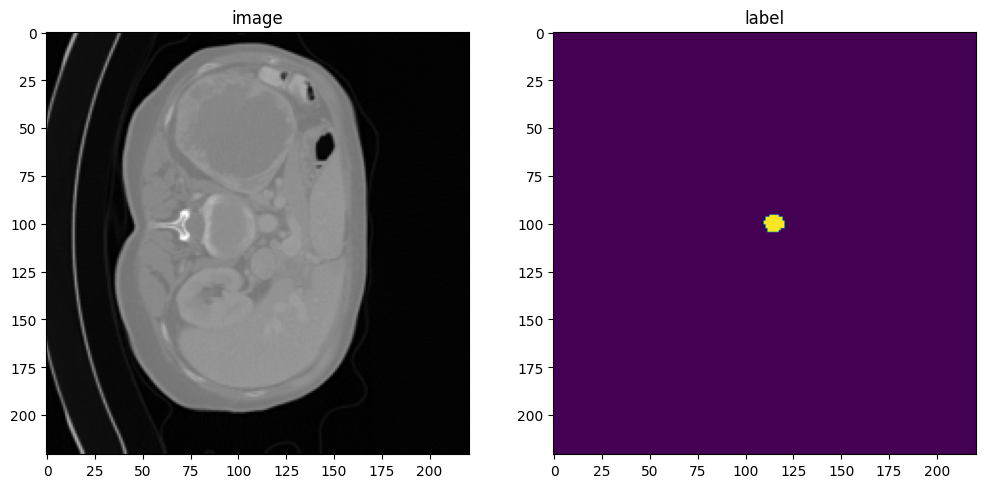

In [140]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
# image = image.numpy()
# image = (image-np.min(image))/(np.max(image)-np.min(image))
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 150], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 150])
plt.show()

In [141]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
# train_ds = Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|██████████| 8/8 [00:13<00:00,  1.71s/it]


In [142]:
print(torch.cuda.is_available())

True


In [143]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

1
NVIDIA GeForce RTX 2070 SUPER


In [144]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

In [145]:
max_epochs = 300
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), 'c:\\Users\\OskarK\\Desktop\\My_AVT\\best_metric_model.pth')
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

----------
epoch 1/300
1/15, train_loss: 0.6776
2/15, train_loss: 0.6793
3/15, train_loss: 0.6772
4/15, train_loss: 0.6764
5/15, train_loss: 0.6687
6/15, train_loss: 0.6747
7/15, train_loss: 0.6674
8/15, train_loss: 0.6692
9/15, train_loss: 0.6733
10/15, train_loss: 0.6652
11/15, train_loss: 0.6657
12/15, train_loss: 0.6666
13/15, train_loss: 0.6475
14/15, train_loss: 0.6695
15/15, train_loss: 0.6606
epoch 1 average loss: 0.6693
----------
epoch 2/300
1/15, train_loss: 0.6507
2/15, train_loss: 0.6576
3/15, train_loss: 0.6613
4/15, train_loss: 0.6374
5/15, train_loss: 0.6638
6/15, train_loss: 0.6572
7/15, train_loss: 0.6460
8/15, train_loss: 0.6577
9/15, train_loss: 0.6593
10/15, train_loss: 0.6454
11/15, train_loss: 0.6430
12/15, train_loss: 0.6552
13/15, train_loss: 0.6577
14/15, train_loss: 0.6372
15/15, train_loss: 0.6443
epoch 2 average loss: 0.6516
saved new best metric model
current epoch: 2 current mean dice: 0.0051
best mean dice: 0.0051 at epoch: 2
----------
epoch 3/300
1/15,

In [146]:
print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.8457 at epoch: 296


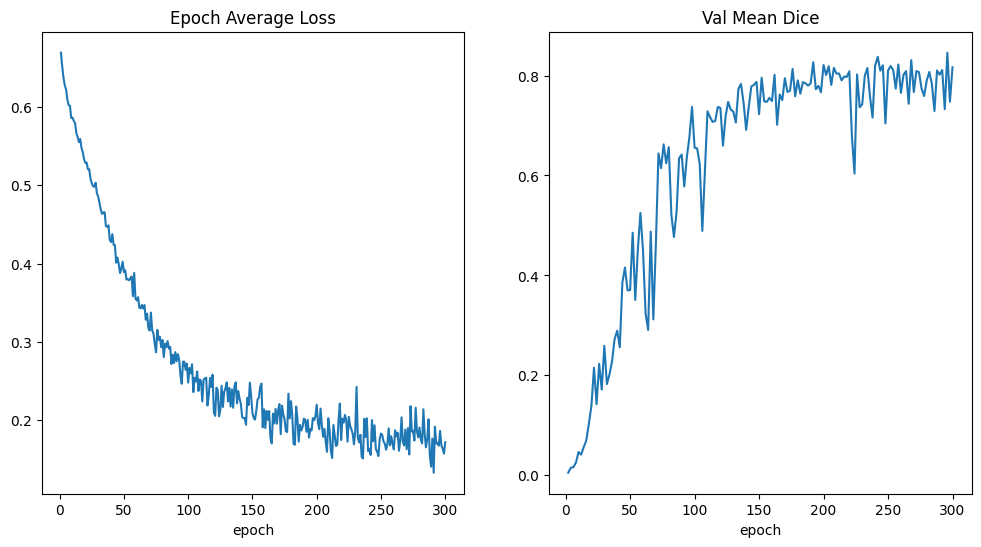

In [147]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

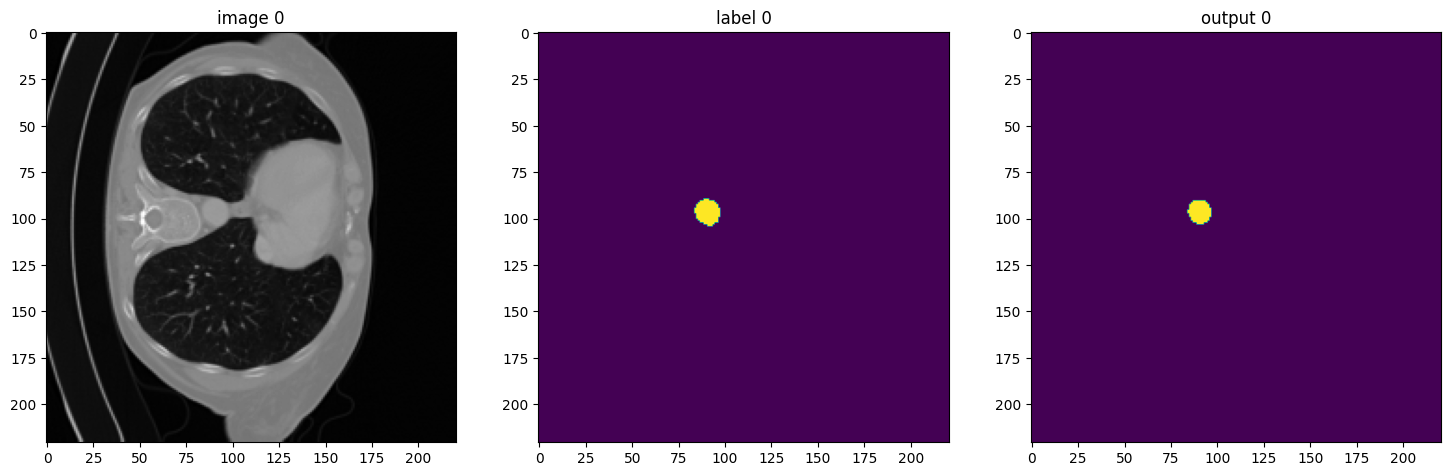

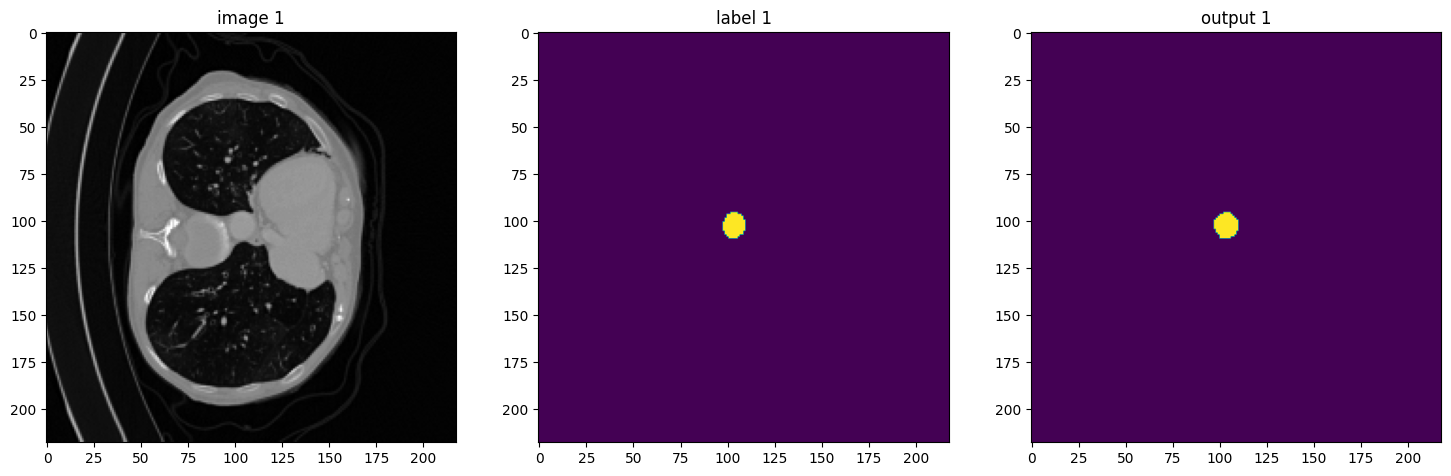

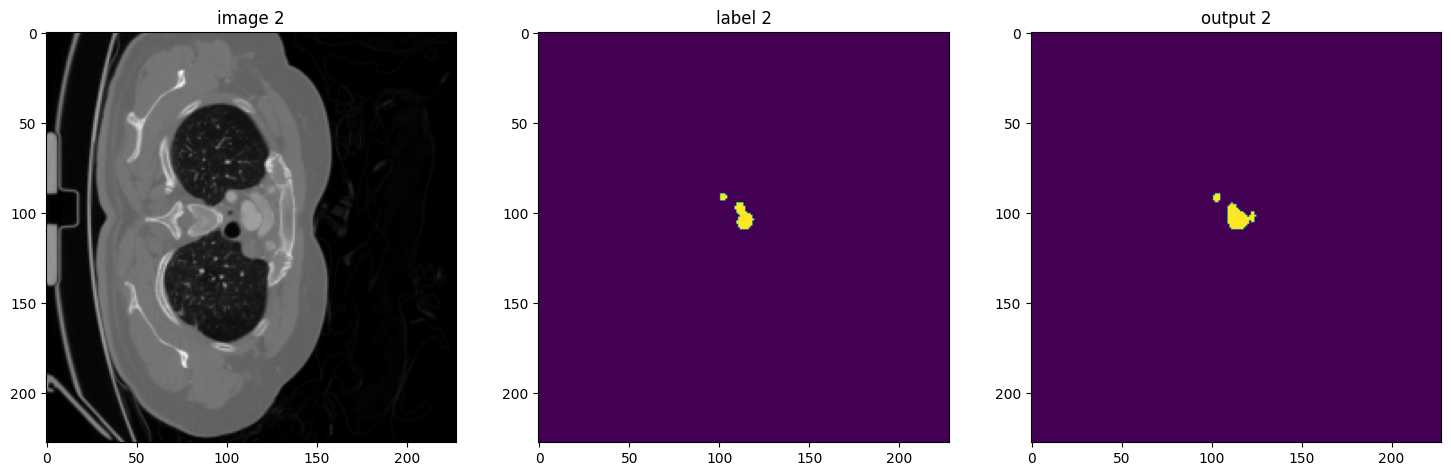

In [150]:
model.load_state_dict(torch.load('c:\\Users\\OskarK\\Desktop\\My_AVT\\best_metric_model.pth'))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size, sw_batch_size, model)
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 200], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 200])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, 200])
        plt.show()
        if i == 2:
            break